## MP & BL Intercomparison

In [1]:
# libs
import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import cartopy.feature as cfeature
import xarray as xr
import glob
import os
import numpy as np
import pandas as pd
from pyproj import CRS, Transformer
import matplotlib as mpl

In [2]:
mp9_bl8_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp9_bl8/'
mp9_bl2_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp9_bl2/'
mp9_bl1_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp9_bl1/'


mp10_bl1_path = '/glade/derecho/scratch/rpurciel/ATMS_746/ARTest/WRF/' #Ryan
mp10_bl2_path = '/glade/derecho/scratch/potter/atm746/ar_mp10_bl2/' #Jolene
mp10_bl8_path = '/glade/derecho/scratch/mcaffee/atm746/ar_mp9_bl8/' #Lauren

mp6_bl1_path = '/glade/derecho/scratch/tfriberg/atm746/ar_mp6_bl1/' #Tucker
mp6_bl2_path = '/glade/derecho/scratch/rbhandari/Modelling_class/wrfv4.7.1/test/em_real/' #Rajan
mp6_bl8_path = '/glade/derecho/scratch/maritza/atm746/ar_mp6_bl8/' #Maritza

mp8_bl1_path = '/glade/derecho/scratch/zavala/atm746/ar_mp8_bl1/' #Luke
mp8_bl2_path = '/glade/derecho/scratch/jhenao/atm746/ar_mp8_bl2/'
mp8_bl8_path = '/glade/derecho/scratch/bmagar/atm746/ar_mp8_bl8/' #Bijita



In [3]:
varneed = ['XLAT', 'XLONG', 'RAINNC', 'RAINC']

def get_time_series(path: str, lat_p: float, lon_p: float) -> np.ndarray:
    """
    gets the path, load the files, get the time series
    at the closest grid cell and returns it
    """
    # get file list at path
    file_list = sorted(glob.glob(path+"wrfout_d02*"))
    # open netcdf files
    ds_mf = xr.open_mfdataset(
        file_list, 
        combine='nested',
        concat_dim='Time',
        drop_variables= [var for var in xr.open_dataset(file_list[0]).data_vars if var not in varneed],
        coords='minimal',
        compat='override'
    )
    # get lat lon
    lat = ds_mf['XLAT'].isel(Time=0)  # (south_north, west_east)
    lon = ds_mf['XLONG'].isel(Time=0)
    # Compute distance (squared) to every grid point
    dist_sq = (lat - lat_p)**2 + (lon - lon_p)**2
    # get the indexes lat, lon of the closest grid
    min_dist_idx = dist_sq.argmin(dim=['south_north', 'west_east'])
    iy = int(min_dist_idx['south_north'])
    ix = int(min_dist_idx['west_east'])
    # add convective and parameterized precip and get it in the station coords
    pr_arr_ts = (ds_mf['RAINNC'] + ds_mf['RAINC']).isel(south_north=iy, west_east=ix).values

    return pr_arr_ts
    

In [4]:
%%time

#coords of station LAYTONVILLE
sta_lat = 39.702330
sta_lon = -123.484910

ts_mp9_bl1 = get_time_series(mp9_bl1_path,sta_lat,sta_lon)
ts_mp9_bl8 = get_time_series(mp9_bl8_path,sta_lat,sta_lon)
ts_mp9_bl2 = get_time_series(mp9_bl2_path,sta_lat,sta_lon)

ts_mp6_bl1 = get_time_series(mp6_bl1_path,sta_lat,sta_lon)
ts_mp6_bl2 = get_time_series(mp6_bl2_path,sta_lat,sta_lon)
ts_mp6_bl8 = get_time_series(mp6_bl8_path,sta_lat,sta_lon)

ts_mp8_bl1 = get_time_series(mp8_bl1_path,sta_lat,sta_lon)
ts_mp8_bl2 = get_time_series(mp8_bl2_path,sta_lat,sta_lon)
ts_mp8_bl8 = get_time_series(mp8_bl8_path,sta_lat,sta_lon)

ts_mp10_bl1 = get_time_series(mp10_bl1_path,sta_lat,sta_lon)
ts_mp10_bl2 = get_time_series(mp10_bl2_path,sta_lat,sta_lon)
ts_mp10_bl8 = get_time_series(mp10_bl8_path,sta_lat,sta_lon)



CPU times: user 2min 49s, sys: 10.5 s, total: 2min 59s
Wall time: 7min 15s


In [5]:
file_list = sorted(glob.glob(mp9_bl8_path+"wrfout_d02*"))
ds_for_time = xr.open_mfdataset(
        file_list, 
        combine='nested',
        concat_dim='Time',
        drop_variables= [var for var in xr.open_dataset(file_list[0]).data_vars if var not in ['XTIME']],
        coords='minimal',
        compat='override'
)

times = ds_for_time['XTIME'].values

In [6]:
# load the observations
sites_path = '/glade/u/home/jhenao/atm746/data_precip/monitoring_sites/'  # replace with your actual file path

site = 'LAYC1'

df = pd.read_csv(
    sites_path+site+'.2024-11-24.csv',
    comment='#'
)
# Drop the first row (units) and reset the index
df = df.drop(0).reset_index(drop=True)


df['Date_Time'] = pd.to_datetime(df['Date_Time'], errors='coerce')
df['precip_accum_set_1'] = pd.to_numeric(df['precip_accum_set_1'].str.strip(), errors='coerce')


In [7]:
# create a dataframe for the observations - note the time is not on the hour
prec_obs = df['precip_accum_set_1'] - df['precip_accum_set_1'][0]
df_obs = pd.DataFrame({'Date': df['Date_Time'], 'LAYC1': prec_obs})
df_obs['Date'] = pd.to_datetime(df_obs['Date']).dt.tz_localize(None)
df_obs['Date']

0     2024-11-18 12:29:00
1     2024-11-18 13:29:00
2     2024-11-18 14:29:00
3     2024-11-18 15:29:00
4     2024-11-18 16:29:00
              ...        
139   2024-11-24 07:29:00
140   2024-11-24 08:29:00
141   2024-11-24 09:29:00
142   2024-11-24 10:29:00
143   2024-11-24 11:29:00
Name: Date, Length: 144, dtype: datetime64[ns]

In [8]:

df_pr = pd.DataFrame(
    {
        'Date': times,
        'MP9_BL8': ts_mp9_bl8,
        'MP9_BL2': ts_mp9_bl2,
        'MP9_BL1': ts_mp9_bl1,
        'MP6_BL1': ts_mp6_bl1,
        'MP6_BL2': ts_mp6_bl2,
        'MP6_BL8': ts_mp6_bl8,
        'MP8_BL1': ts_mp8_bl1,
        'MP8_BL2': ts_mp8_bl2,
        'MP8_BL8': ts_mp8_bl8,
        'MP10_BL1': ts_mp10_bl1,
        'MP10_BL2': ts_mp10_bl2,
        'MP10_BL8': ts_mp10_bl8
    }
)


df_pr['Date'] = pd.to_datetime(df_pr['Date']).dt.tz_localize(None)



In [9]:
# combine melting the df
df_long = df_pr.melt(id_vars='Date', var_name='MP_BL', value_name='Value')
# get value of MP and BL
df_long[['MP', 'BL']] = df_long['MP_BL'].str.extract(r'(MP\d+)_BL(\d+)')

In [10]:
# mean for each MP and BL
mean_per_bl = df_long.groupby(['Date', 'BL'])['Value'].mean().reset_index()
mean_per_bl_pivot = mean_per_bl.pivot(index='Date', columns='BL', values='Value')

mean_per_mp = df_long.groupby(['Date', 'MP'])['Value'].mean().reset_index()
mean_per_mp_pivot = mean_per_mp.pivot(index='Date', columns='MP', values='Value')

<Axes: xlabel='Date'>

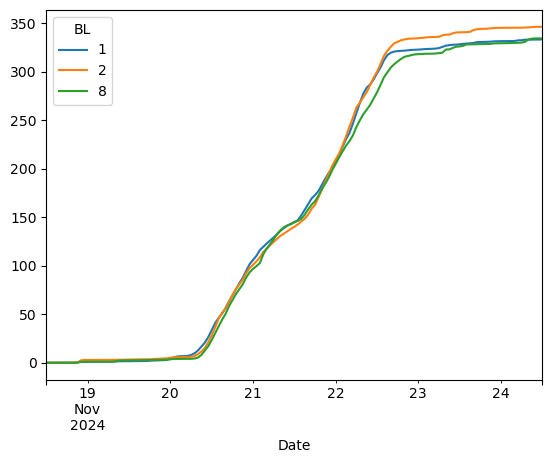

In [11]:
mean_per_bl_pivot.plot()

<Axes: xlabel='Date'>

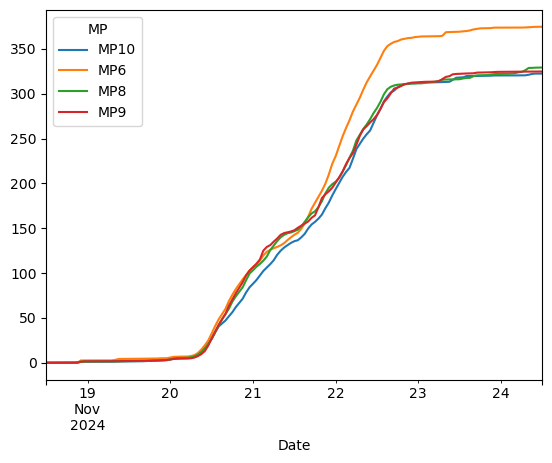

In [12]:
mean_per_mp_pivot.plot()

<Axes: xlabel='Date'>

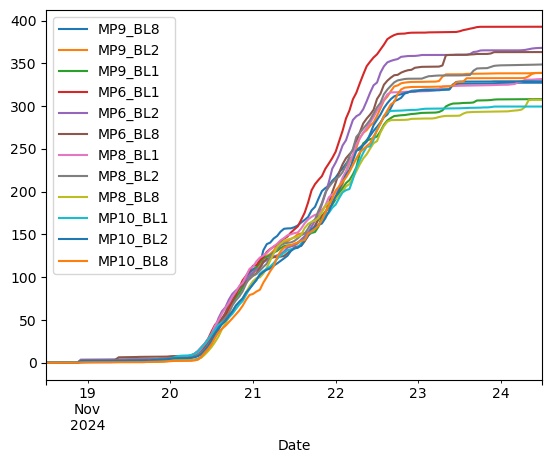

In [13]:
df_pr.plot(x='Date')

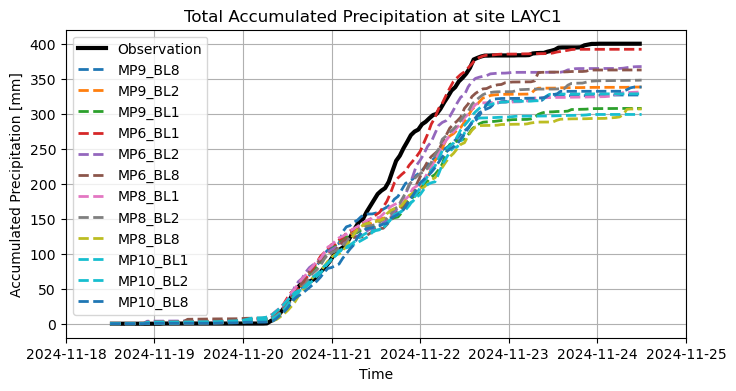

In [14]:

# colors for wrf sims
n_colors = len(df_pr.columns) - 1
cmap = mpl.colormaps['tab10']
color_indices = np.linspace(0, 1, n_colors)
# Get the colors from the colormap
colors = cmap(color_indices)

plt.figure(figsize=(8, 4))

plt.xlim(pd.Timestamp("2024-11-18"), pd.Timestamp("2024-11-25"))

# from station
plt.plot(df_obs['Date'], prec_obs, label="Observation", linewidth=3, color='black')
# from wrf
for i, col in enumerate(df_pr.columns):
    if col != 'Date':
        plt.plot(df_pr['Date'], 
                 df_pr[col], 
                 label=col,
                 color=colors[i % len(colors)],
                 linestyle='--',
                 linewidth=2)

plt.xlabel('Time')
plt.ylabel('Accumulated Precipitation [mm]')
plt.title(f"Total Accumulated Precipitation at site {site} ")

plt.legend()

plt.grid(True)


In [15]:
def get_time_series(path: str) -> np.ndarray:
    """
    gets the path, load the last files, returns the total precip
    """
    # get file list at path
    file_list = sorted(glob.glob(path+"wrfout_d02*"))
    # open netcdf files
    ds = xr.open_dataset(
        file_list[-1], 
        drop_variables= [var for var in xr.open_dataset(file_list[0]).data_vars if var not in varneed],

    )
    # add convective and parameterized precip and get it in the station coords
    pr_arr = (ds['RAINNC'] + ds['RAINC']).squeeze()

    return pr_arr

## Spatial accumulated precip

In [16]:
%%time
# get arrays of precipitation at last hour - accumulated
pr_mp9_bl8 = get_time_series(mp9_bl8_path)
pr_mp9_bl2 = get_time_series(mp9_bl2_path)
pr_mp9_bl1 = get_time_series(mp9_bl1_path)
pr_mp6_bl1 = get_time_series(mp6_bl1_path)
pr_mp6_bl2 = get_time_series(mp6_bl2_path)
pr_mp6_bl8 = get_time_series(mp6_bl8_path)
pr_mp8_bl1 = get_time_series(mp8_bl1_path)
pr_mp8_bl2 = get_time_series(mp8_bl2_path)
pr_mp8_bl8 = get_time_series(mp8_bl8_path)
pr_mp10_bl1 = get_time_series(mp10_bl1_path)
pr_mp10_bl2 = get_time_series(mp10_bl2_path)
pr_mp10_bl8 = get_time_series(mp10_bl8_path)

# dictionary of precp arrays
dc_pr_arrs = {
    'mp9_bl1': pr_mp9_bl1, 
    'mp9_bl8': pr_mp9_bl8, 
    'mp9_bl2': pr_mp9_bl2, 
    'mp6_bl1': pr_mp6_bl1, 
    'mp6_bl2': pr_mp6_bl2, 
    'mp6_bl8': pr_mp6_bl8, 
    'mp8_bl1': pr_mp8_bl1, 
    'mp8_bl2': pr_mp8_bl2, 
    'mp8_bl8': pr_mp8_bl8,
    'mp10_bl1': pr_mp10_bl1,
    'mp10_bl2': pr_mp10_bl2,
    'mp10_bl8': pr_mp10_bl8
}

CPU times: user 1.99 s, sys: 86.1 ms, total: 2.07 s
Wall time: 3.03 s


In [17]:
file = sorted(glob.glob(mp9_bl8_path+"wrfout_d02*"))[0]
# open netcdf files
ds = xr.open_dataset(
    file,
    drop_variables= [var for var in xr.open_dataset(file_list[0]).data_vars if var not in ['XLAT','XLONG','LANDMASK']],
)
# add convective and parameterized precip and get it in the station coords
lat = ds['XLAT'].squeeze()
lon = ds['XLONG'].squeeze()
lmask = ds['LANDMASK'].squeeze()

In [18]:
# colormap creation
import matplotlib as mpl
from matplotlib.colors import LinearSegmentedColormap

clrs = [
    "#FAFAFA", 
    "#94A494", 
    "#02C702", 
    "#017301", 
    "#117901", 
    "#C6C002", 
    "#C7C402", 
    "#B59400", 
    "#B88F00", 
    "#C77100", 
    "#C70000", 
    "#960000", 
    "#990010", 
    "#BC00A5", 
    "#C400C7", 
    "#8739A8", 
    "#7A45A1", 
]
cmap = LinearSegmentedColormap.from_list('div', clrs)
levs = np.arange(10, 510, 10)
levs_prec = np.insert(levs, 0, 0.001)
norm = mpl.colors.BoundaryNorm(levs_prec, cmap.N, clip=True)

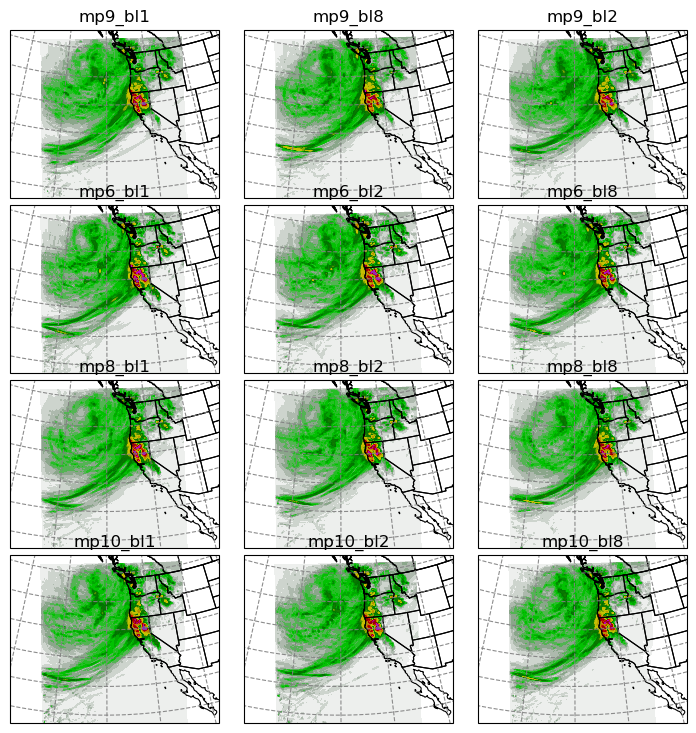

In [19]:
## PLOT
lon_min = lon.min()
lon_max = lon.max()
lat_min = lat.min()
lat_max = lat.max()


# a Lambert projection using ref lat and lon from namelist.wps
projection = ccrs.LambertConformal(central_longitude=-130.392, central_latitude=35.174)


fig, ax = plt.subplots(
    nrows=4, 
    ncols=3,
    subplot_kw={'projection': projection},
    figsize=(9, 9), 
    sharex=True, 
    sharey=True
)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.02, hspace=0.04)

ax = ax.flatten()


for i in range(len(ax)):
    ## bounding box limits
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max]) 
    # add coastline, states and borders
    ax[i].add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax[i].add_feature(cfeature.STATES, linewidth=0.8)
    ax[i].add_feature(cfeature.BORDERS, linewidth=0.8)
    #add grid
    grid = ax[i].gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    color='gray', alpha=0.9, linestyle='--')
    
    grid.left_labels = grid.right_labels = False
    grid.top_labels = grid.bottom_labels = False
   
    p1 = ax[i].contourf(
        lon, lat, list(dc_pr_arrs.values())[i],
        levels=levs_prec,
        cmap=cmap,
        extend='max',
        transform=ccrs.PlateCarree()
    )

    ax[i].set_title(list(dc_pr_arrs.keys())[i])
    
plt.show()

In [ ]:

lon_min = -130
lon_max = -114
lat_min = 35
lat_max = lat.max()


# a Lambert projection using ref lat and lon from namelist.wps
projection = ccrs.LambertConformal(central_longitude=-130.392, central_latitude=35.174)


fig, ax = plt.subplots(
    nrows=2, 
    ncols=6,
    subplot_kw={'projection': projection},
    figsize=(9, 5), 
    sharex=True, 
    sharey=True
)

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.01, hspace=0.1)

ax = ax.flatten()


for i in range(len(ax)):
    ## bounding box limits
    ax[i].set_extent([lon_min, lon_max, lat_min, lat_max]) 
    # add coastline, states and borders
    ax[i].add_feature(cfeature.COASTLINE, linewidth=0.8)
    ax[i].add_feature(cfeature.STATES, linewidth=0.8)
    ax[i].add_feature(cfeature.BORDERS, linewidth=0.8)
    #add grid
    grid = ax[i].gridlines(draw_labels=True, x_inline=False, y_inline=False,
                    color='gray', alpha=0.9, linestyle='--')
    
    grid.left_labels = grid.right_labels = False
    grid.top_labels = grid.bottom_labels = False

    arr = list(dc_pr_arrs.values())[i]

    arr_masked = arr.where(lmask == 1)
    
    p1 = ax[i].contourf(
        lon, lat, arr_masked,
        levels=levs_prec,
        cmap=cmap,
        extend='max',
        transform=ccrs.PlateCarree()
    )

    ax[i].set_title(list(dc_pr_arrs.keys())[i])

cax = fig.add_axes([ax[9].get_position().x0, ax[9].get_position().y0 - 0.05, ax[11].get_position().x1-ax[6].get_position().x0, 0.015])
cbar=plt.colorbar(p1, pad=0.005,ticks=levs_prec[::5],cax=cax,orientation="horizontal")
#cbar.ax.tick_params(labelsize=8)
cbar.set_label('Accumulated Total Precip [mm]')


    
plt.show()